## Sirius/LNLS - Scientific Computing Group
## Planewave CDI

This notebook contains an example on how reconstruct a synthetic planewave CDI dataset using sscCdi.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from sscCdi import planewave

## Load/create a synthetic 3d diffraction pattern 

In [2]:
#### If you have sscPhantom installed and correctly configured, you can use the following

In [3]:
N    = 256 # 1758  #1536  #1536 #256  

## create observed data from phantom
zoom = {2:10,
        8:3,
        64:1,
        128:0.55,
        256:0.35,
        512:0.20,
        1024:0.1,
        1368:0.05,
        1500:0.025,
        1800:0.013}
from sscPhantom import mario
phantom = mario.createMario(shape=N, noise=False, zoom=zoom[N])  
phantom = (phantom-phantom.min())/(phantom.max()-phantom.min()) 
phase = phantom.copy()

# create phase 
phantom = phantom.astype(np.complex64) 
phantom = phantom*np.exp(1j*(phase))

# create data
data = (np.abs(np.fft.fftn(phantom)).real)
 
# check data shape
print(data.shape)

 
b = 25

mario: (256, 256, 256) 33.6MB
(256, 256, 256)


In [4]:
# # np.load("/ibira/lnls/labs/tepui/home/mauro.brandao/data/mario256/diff3d.npy").shape
# # np.load("/ibira/lnls/labs/tepui/home/mauro.brandao/data/mario256/phantom.npy").shape
# np.save("/ibira/lnls/labs/tepui/home/mauro.brandao/data/mario256/diff3d.npy", data)
# np.save("/ibira/lnls/labs/tepui/home/mauro.brandao/data/mario256/phantom.npy", phantom)

## View synthetic data

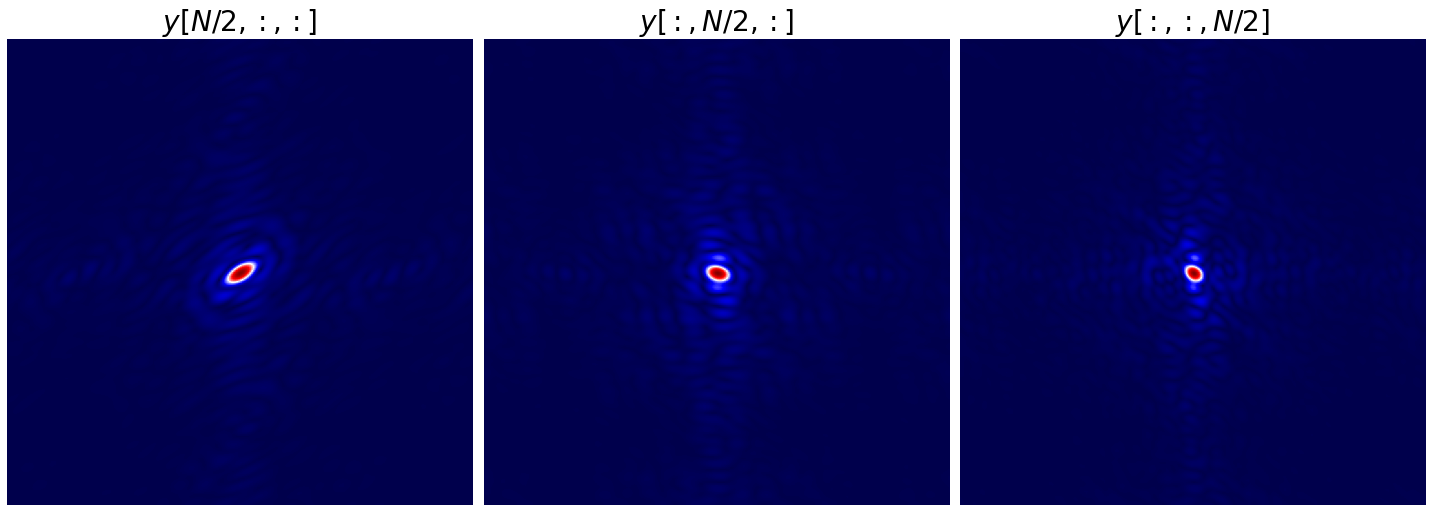

In [5]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)
data = np.fft.fftshift(data)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1,3, width_ratios=[1, 1, 1])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
# cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(np.abs(data)[N//2, unpad:N-unpad, unpad:N-unpad], cmap='seismic')
ax0.axis('off')
ax0.set_title(r"$y[N/2,:,:]$",fontsize = 28)
im1 = ax1.imshow(np.abs(data)[unpad:N-unpad, N//2, unpad:N-unpad], cmap='seismic')
ax1.axis('off')
ax1.set_title(r"$y[:,N/2,:]$",fontsize = 28)
im2 = ax2.imshow(np.abs(data)[unpad:N-unpad, unpad:N-unpad, N//2], cmap='seismic')
ax2.axis('off')
ax2.set_title(r"$y[:,:,N/2]$",fontsize = 28)

# Create the color bar in the dedicated space
# cbar = fig.colorbar(im0, cax=cax)
# cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('mario_data.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

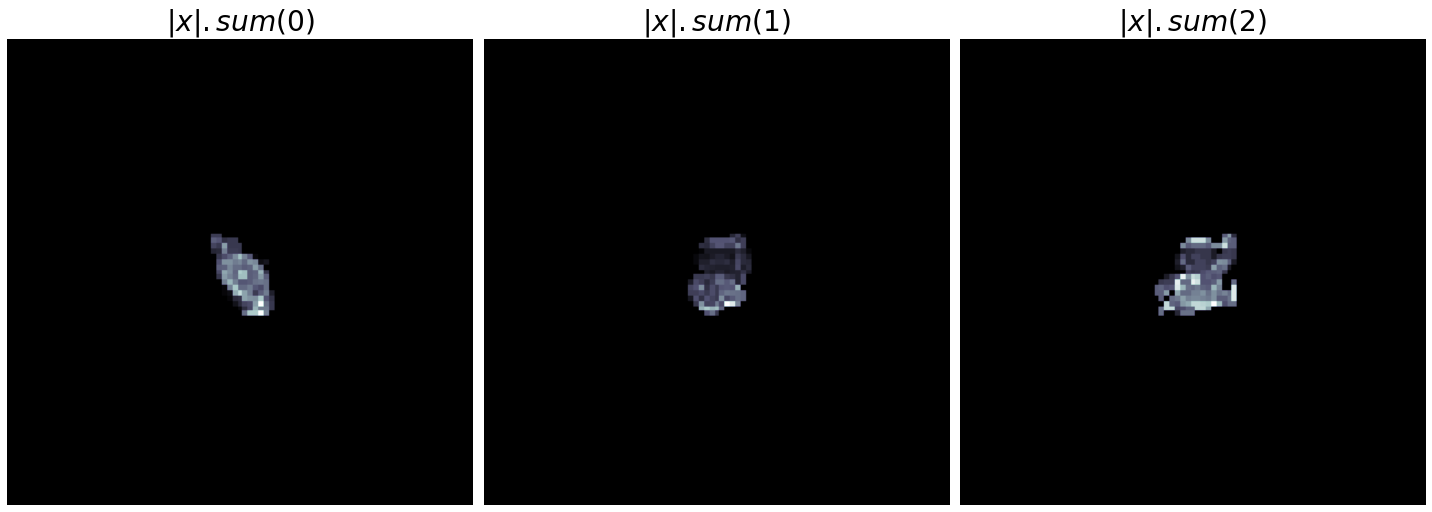

In [6]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1 ])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
# cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(np.abs(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(0), cmap='bone')
ax0.axis('off')
ax0.set_title(r"$|x|.sum(0)$",fontsize = 28)
im1 = ax1.imshow(np.abs(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(1), cmap='bone')
ax1.axis('off')
ax1.set_title(r"$|x|.sum(1)$",fontsize = 28)
im2 = ax2.imshow(np.abs(phantom)[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(2), cmap='bone')
ax2.axis('off')
ax2.set_title(r"$|x|.sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
# cbar = fig.colorbar(im0, cax=cax)
# cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('mario.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

## Run! 

In [7]:
# params
dic = {} 
# dic['dimension'] = N
dic['gpus'] = [0] # [0,1,2,3,4,5] 
dic['timing'] = True   
dic["swap_d_x"] = False
dic["map_d_signal"] = False
dic["map_d_support"] = False
  
dic['method'] = {0:{"name": "HIO",
                    "niter": 10000,                        
                    "shrinkwrap_subiter": 20,
                    "initial_shrinkwrap_subiter": 20,
                    "beta": 0.95,
                    "beta_update": 7,
                    "beta_reset_subiter": 20,
                    "sigma": 6.0/np.pi,
                    "sigma_mult": 0.99,
                    "shrinkwrap_threshold": 6.0,
                    "shrinkwrap_iter_filter": "amplitude", 
                    "extra_constraint": None,               
                    "extra_constraint_subiter": 1,
                    "initial_extra_constraint_subiter": 0},
                1:{"name": "ER",
                   "niter": 200}}
            

 
# support parameters and initial data
sup_data =  None
dic['support'] = { 'p': 10, 'r': 0.5, 'data':sup_data} 

# initial object data 
dic['obj_input'] = None

tic = time.time()
out_obj, out_finsup = planewave.pwcdi3d(data, dic)
toc = time.time() - tic

print('Elapsed time for HIO3D: {} sec'.format(toc))

ssc-cdi: Memory available at selected GPUs [ before allocation ]
ssc-cdi: Memory available at selected GPUs [ after allocation ]


ssc-cdi: Available GPUs at this node: 1
ssc-cdi: Distributing data through GPUs: 0 
 |-> GPU[0] - 0.432434 GiB  used / 39.153687 GiB available

ssc-cdi: plan created.
ssc-cdi: plan size: 0.125000 GiB.
 |-> GPU[0] - 1.061340 GiB  used / 38.524780 GiB available

ssc-cdi: Creating synthetic initial support
ssc-cdi: setting the initial support - 976.555725 ms
ssc-cdi: Creating initial object data from the diffraction pattern.
ssc-cdi: setting inital data - 1.432896 ms
ssc-cdi: Algorithm Name = HIO
ssc-cdi: Iteration = 10000
ssc-cdi: Shrink-wrap sub-iteration = 20
ssc-cdi: Initial shrink-wrap sub-iteration = 20
ssc-cdi: Extra constraint code = 0
ssc-cdi: Initial extra constraint sub-iteration = 0
ssc-cdi: Extra constraint sub-iteration = 1
ssc-cdi: Shrink-wrap threshold = 6.000000
ssc-cdi: Shrink-wrap iteration filter = 1
ssc-cdi: Shrink-wrap mask multiply = 0
ssc-cdi: Shrink-wrap FFT shift Gaussian = false
ssc-cdi: Sigma = 1.909859
ssc-cdi: Sigma multiplier = 0.990000
ssc-cdi: Beta = 0.950

## View results

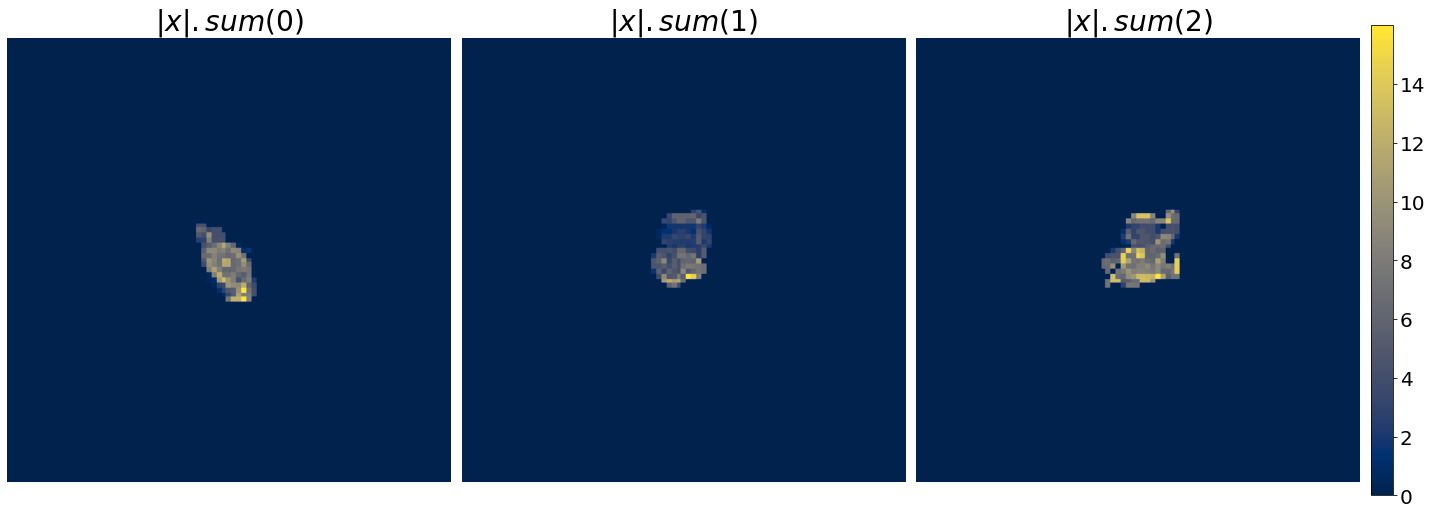

In [8]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

out_ampli = np.abs(out_obj)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(out_ampli[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(0), cmap='cividis')
ax0.axis('off')
ax0.set_title(r"$|x|.sum(0)$",fontsize = 28)
im1 = ax1.imshow(out_ampli[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(1), cmap='cividis')
ax1.axis('off')
ax1.set_title(r"$|x|.sum(1)$",fontsize = 28)
im2 = ax2.imshow(out_ampli[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(2), cmap='cividis')
ax2.axis('off')
ax2.set_title(r"$|x|.sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
cbar = fig.colorbar(im0, cax=cax)
cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('peanuts/peanut_recon_ampli_1024.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

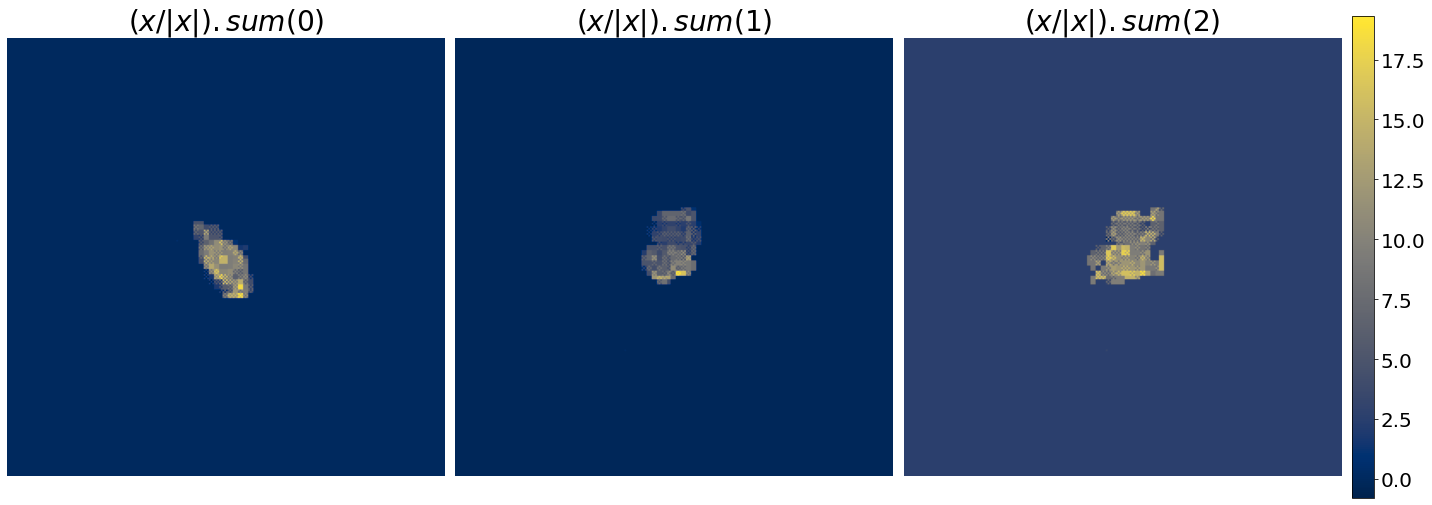

In [9]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
cax = plt.subplot(gs[3])

#out_phase =  np.fromfile(dic['output']+'.phase', dtype=np.float32).reshape([M,M,M])  
out_phase = np.angle(out_obj)
out_phase[out_phase == -np.pi] = 0
out_phase[out_phase == np.pi] = 0
# out_phase = out_phase #+0.125
#out_phase = out_phase*finsup

# Plot the images
im0 = ax0.imshow(out_phase[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(0), cmap='cividis')
ax0.axis('off')
ax0.set_title(r"$(x/|x|).sum(0)$",fontsize = 28)
im1 = ax1.imshow(out_phase[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(1), cmap='cividis')
ax1.axis('off')
ax1.set_title(r"$(x/|x|).sum(1)$",fontsize = 28)
im2 = ax2.imshow(out_phase[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(2), cmap='cividis')
ax2.axis('off')
ax2.set_title(r"$(x/|x|).sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
cbar = fig.colorbar(im0, cax=cax)
cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed
# 
# plt.savefig('peanuts/peanut_recon_phase_1024.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()

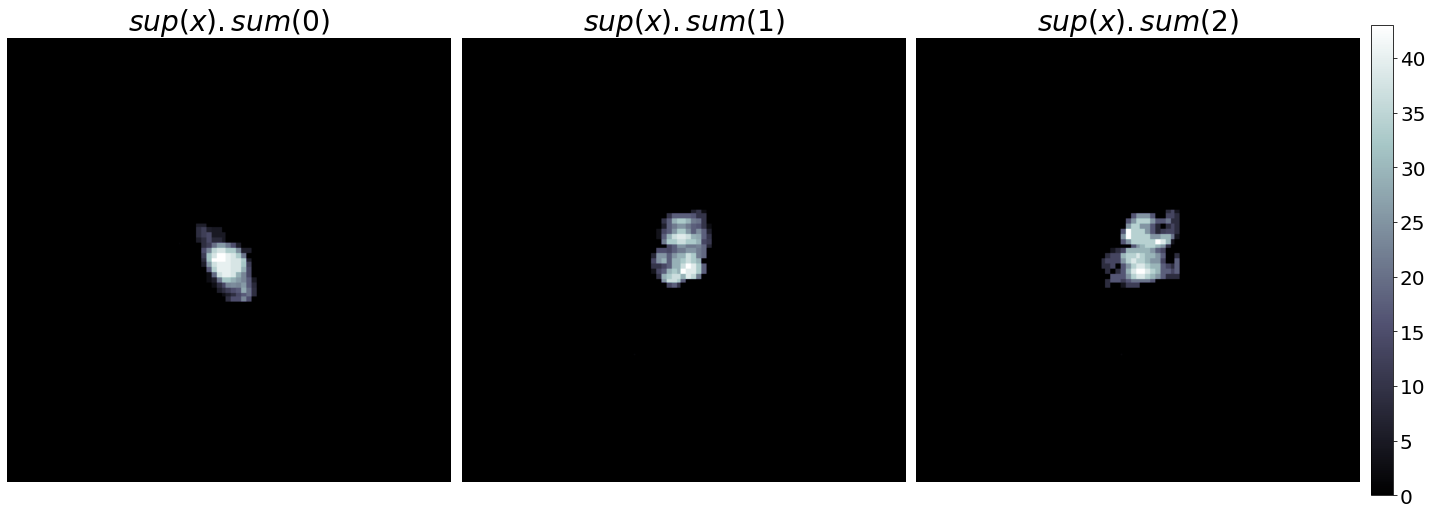

In [10]:
# Assuming out_ampli and N are defined
unpad = 0 # int(N // 4)

out_finsup = out_finsup.astype(int)
 
# Create a gridspec with 4 columns, the last column being for the color bar
fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Adjust width_ratios as needed

# Create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
cax = plt.subplot(gs[3])

# Plot the images
im0 = ax0.imshow(out_finsup[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(0), cmap='bone')
ax0.axis('off')
ax0.set_title(r"$sup(x).sum(0)$",fontsize = 28)
im1 = ax1.imshow(out_finsup[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(1), cmap='bone')
ax1.axis('off')
ax1.set_title(r"$sup(x).sum(1)$",fontsize = 28)
im2 = ax2.imshow(out_finsup[unpad:N-unpad, unpad:N-unpad, unpad:N-unpad].sum(2), cmap='bone')
ax2.axis('off')
ax2.set_title(r"$sup(x).sum(2)$",fontsize = 28)

# Create the color bar in the dedicated space
cbar = fig.colorbar(im0, cax=cax)
cbar.ax.tick_params(labelsize=20)  # Adjust the fontsize as needed

# plt.savefig('peanuts/peanut_recon_ampli_1024.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

plt.tight_layout()
plt.show()